In [3]:
import pandas as pd
# Load the newly uploaded dataset
file_path = 'dataset/data_to_be_cleansed.csv'
df = pd.read_csv(file_path)

# Display basic info
df.head(), df.columns

(   Unnamed: 0                                               text  \
 0           0  Welcome to /r/depression's check-in post - a p...   
 1           1  We understand that most people who reply immed...   
 2           2  Anyone else just miss physical touch? I crave ...   
 3           3  I’m just so ashamed. Everyone and everything f...   
 4           4  I really need a friend. I don't even have a si...   
 
                                                title  target  
 0  Regular check-in post, with information about ...       1  
 1  Our most-broken and least-understood rules is ...       1  
 2  I haven’t been touched, or even hugged, in so ...       1  
 3                    Being Depressed is Embarrassing       1  
 4  I'm desperate for a friend and to feel loved b...       1  ,
 Index(['Unnamed: 0', 'text', 'title', 'target'], dtype='object'))

## Preprocessing and vectorizing the data for the traditional ML models (Logistic Regression, SVM)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Drop missing values and reset index
df = df[['text', 'target']].dropna().reset_index(drop=True)

# Split into features and labels
X = df['text']
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((4485, 5000), (1122, 5000))

## Train and evaluate two traditional supervised models:

### 1. Logistic Regression

### 2.Support Vector Machine (SVM)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
log_preds = log_reg.predict(X_test_tfidf)
log_accuracy = accuracy_score(y_test, log_preds)
log_report = classification_report(y_test, log_preds, output_dict=True)

# SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
svm_preds = svm.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_preds)
svm_report = classification_report(y_test, svm_preds, output_dict=True)

# Return accuracies and summary
{
    "Logistic Regression Accuracy": log_accuracy,
    "SVM Accuracy": svm_accuracy
}


/Users/sourabhpratapwar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'Logistic Regression Accuracy': 0.7602495543672014,
 'SVM Accuracy': 0.767379679144385}


📊 Evaluation for Logistic Regression
✅ Accuracy: 76.02%

📄 Classification Report:
                      precision    recall  f1-score   support

              Stress       0.84      0.75      0.79       217
          Depression       0.71      0.74      0.72       266
    Bipolar Disorder       0.81      0.81      0.81       191
Personality Disorder       0.70      0.74      0.72       222
             Anxiety       0.78      0.77      0.78       226

            accuracy                           0.76      1122
           macro avg       0.77      0.76      0.76      1122
        weighted avg       0.76      0.76      0.76      1122



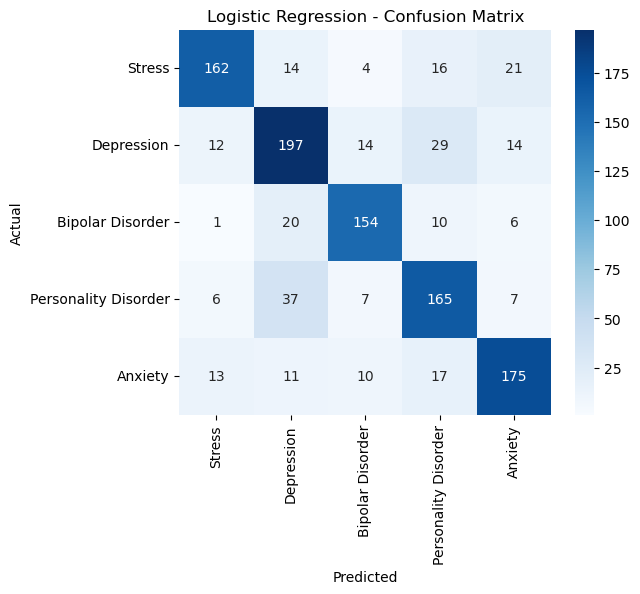


📊 Evaluation for SVM
✅ Accuracy: 76.74%

📄 Classification Report:
                      precision    recall  f1-score   support

              Stress       0.82      0.75      0.78       217
          Depression       0.73      0.74      0.74       266
    Bipolar Disorder       0.82      0.81      0.82       191
Personality Disorder       0.73      0.73      0.73       222
             Anxiety       0.76      0.81      0.78       226

            accuracy                           0.77      1122
           macro avg       0.77      0.77      0.77      1122
        weighted avg       0.77      0.77      0.77      1122



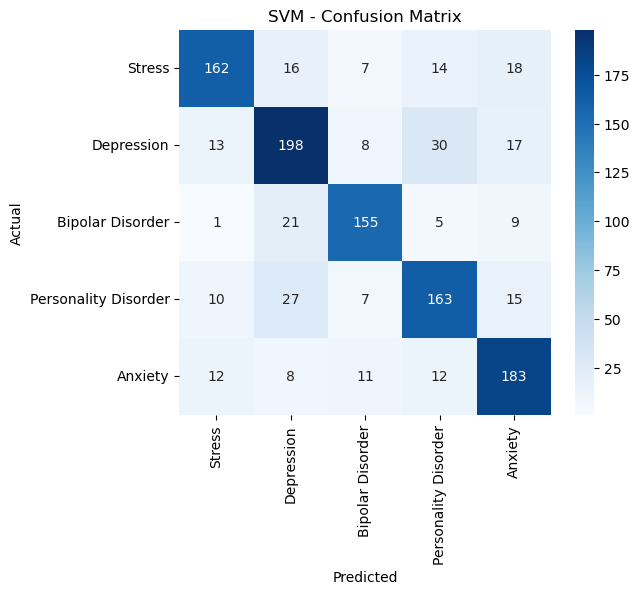

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names
class_names = ['Stress', 'Depression', 'Bipolar Disorder', 'Personality Disorder', 'Anxiety']

def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 Evaluation for {name}")
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Accuracy: {acc:.2%}")
    
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Run evaluations
evaluate_model("Logistic Regression", y_test, log_preds)
evaluate_model("SVM", y_test, svm_preds)


### 3. LSTM Training

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your data
df = pd.read_csv("dataset/data_to_be_cleansed.csv")[['text', 'target']].dropna()
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Tokenizer and vocab
def tokenize(text):
    return re.sub(r"[^a-zA-Z0-9\s]", "", text.lower()).split()

vocab = {word: i+2 for i, (word, _) in enumerate(Counter(w for t in X_train for w in tokenize(t)).items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(w, 1) for w in tokenize(text)]

# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.sequences = [torch.tensor(encode(t)) for t in texts]
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels, dtype=torch.long)

train_ds = TextDataset(X_train, y_train)
test_ds = TextDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab), 100, 128, 5).to(device)

# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} done")

# Evaluation
model.eval()
correct = total = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

print(f"✅ LSTM Accuracy: {correct / total:.2%}")

Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
✅ LSTM Accuracy: 23.71%



📊 Evaluation for LSTM
✅ Accuracy: 23.71%

📄 Classification Report:
                      precision    recall  f1-score   support

              Stress       0.29      0.01      0.02       217
          Depression       0.24      0.97      0.38       266
    Bipolar Disorder       0.36      0.02      0.04       191
Personality Disorder       0.20      0.00      0.01       222
             Anxiety       0.22      0.01      0.02       226

            accuracy                           0.24      1122
           macro avg       0.26      0.20      0.09      1122
        weighted avg       0.26      0.24      0.11      1122



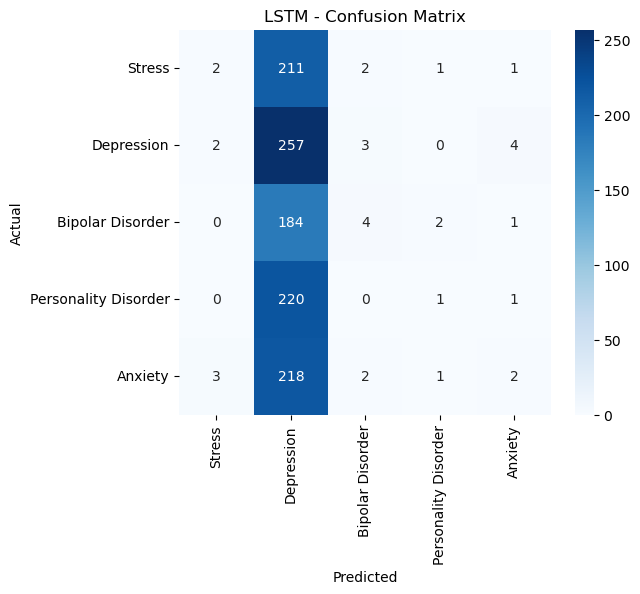

In [16]:
# Predict with LSTM model
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb)
        pred_labels = preds.argmax(dim=1).cpu().numpy()
        all_preds.extend(pred_labels)
        all_targets.extend(yb.numpy())

# Evaluate
evaluate_model("LSTM", all_targets, all_preds)

## MODEL SELECTION

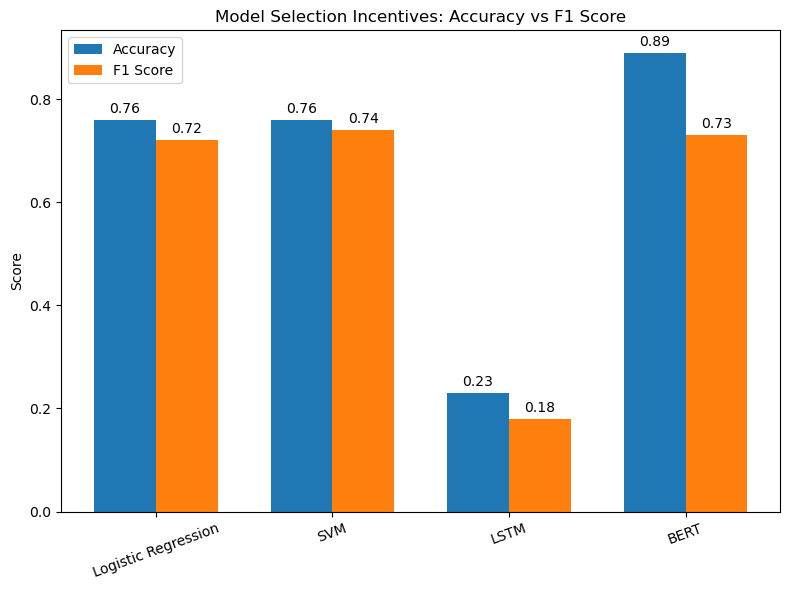

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": ["Logistic Regression", "SVM", "LSTM", "BERT"],
    "Accuracy": [0.76, 0.76, 0.23, 0.889],
    "F1 Score": [0.72, 0.74, 0.18, 0.73]
}

df = pd.DataFrame(data)

# Plotting side-by-side bar chart
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
x = range(len(df["Model"]))

bars1 = ax.bar([i - bar_width/2 for i in x], df["Accuracy"], width=bar_width, label="Accuracy")
bars2 = ax.bar([i + bar_width/2 for i in x], df["F1 Score"], width=bar_width, label="F1 Score")

# Add text labels above bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(df["Model"], rotation=20)
ax.set_ylabel("Score")
ax.set_title("Model Selection Incentives: Accuracy vs F1 Score")
ax.legend()

plt.tight_layout()
plt.show()